# 8-Puzzle

In [1]:
from abc import ABC, abstractmethod
from matplotlib import animation
from IPython.display import HTML

import random
import heapq
import numpy as np
import matplotlib.pyplot as plt

# N-Puzzle
N = 8

# number of cells
K = int((N + 1 + 1) ** 0.5)

In [2]:
class Puzzle:
    parent = None
    state = None
    operator = None
    zero = None
    depth = 0
    cost = 0

    def __init__(self, state, parent=None, operator=None, depth=0):
        self.parent = parent
        self.state = np.array(state)
        self.operator = operator
        self.depth = depth
        self.zero = self.find_0()
        self.cost = self.depth + self.manhattan()

    def __lt__(self, other):
        if self.cost != other.cost:
            return self.cost < other.cost
        else:
            op_pr = {'Up': 0, 'Down': 1, 'Left': 2, 'Right': 3}
            return op_pr[self.operator] < op_pr[other.operator]

    def __str__(self):
        return str(self.state[:3]) + '\n' \
               + str(self.state[3:6]) + '\n' \
               + str(self.state[6:]) + ' ' + str(self.depth) + str(self.operator) + '\n'

    def goal_test(self):
        if np.array_equal(self.state, np.arange(9)):
            return True
        else:
            return False

    def find_0(self):
        for i in range(9):
            if self.state[i] == 0:
                return i

    def manhattan(self):
        state = self.index(self.state)
        goal = self.index(np.arange(9))
        return sum((abs(state // 3 - goal // 3) + abs(state % 3 - goal % 3))[1:])

    @staticmethod
    def index(state):
        index = np.array(range(9))
        for x, y in enumerate(state):
            index[y] = x
        return index

    def swap(self, i, j):
        new_state = np.array(self.state)
        new_state[i], new_state[j] = new_state[j], new_state[i]
        return new_state

    def up(self):
        if self.zero > 2:
            return Puzzle(self.swap(self.zero, self.zero - 3), self, 'Up', self.depth + 1)
        else:
            return None

    def down(self):
        if self.zero < 6:
            return Puzzle(self.swap(self.zero, self.zero + 3), self, 'Down', self.depth + 1)
        else:
            return None

    def left(self):
        if self.zero % 3 != 0:
            return Puzzle(self.swap(self.zero, self.zero - 1), self, 'Left', self.depth + 1)
        else:
            return None

    def right(self):
        if (self.zero + 1) % 3 != 0:
            return Puzzle(self.swap(self.zero, self.zero + 1), self, 'Right', self.depth + 1)
        else:
            return None

    def neighbors(self):
        neighbors = [self.up(), self.down(), self.left(), self.right()]
        return list(filter(None, neighbors))

    __repr__ = __str__

# A* Search

In [12]:
class Solver(ABC):
    solution = None
    frontier = None
    max_depth = 0
    nodes_expanded = 0
    initial_state = None
    explored_nodes = set()

    def __init__(self, initial_state):
        self.initial_state = initial_state

    def ancestral_chain(self):
        current = self.solution
        chain = [current]
        while current is not None and current.parent is not None:
            chain.append(current.parent)
            current = current.parent
        return chain

    @property
    def path(self):
        return [node.operator for node in self.ancestral_chain()[-2::-1]]

    @abstractmethod
    def solve(self):
        pass

    def set_solution(self, board):
        self.solution = board
        self.nodes_expanded = len(self.explored_nodes) - len(self.frontier) - 1


class AStar(Solver):
    def __init__(self, initial_state):
        super(AStar, self).__init__(initial_state)
        self.frontier = []
        self.states = []

    def solve(self):
        heapq.heappush(self.frontier, self.initial_state)
        while self.frontier:
            board = heapq.heappop(self.frontier)
            self.explored_nodes.add(tuple(board.state))
            self.states.append(board.state.copy())

            if board.goal_test():
                self.set_solution(board)
                break

            for neighbor in board.neighbors():
                if tuple(neighbor.state) not in self.explored_nodes:
                    heapq.heappush(self.frontier, neighbor)
                    self.explored_nodes.add(tuple(neighbor.state))
                    self.max_depth = max(self.max_depth, neighbor.depth)
        return

In [4]:
# draw board in table format
def draw_cells(blocks):
    count, col = 0, 0
    edge = '+' + '-' * 3
    print(edge * K + '+')

    for num in blocks:
        if count == 3:
            print('|\n' + edge * K + '+')

            count = 0
            col += 1
            if col % K == 0:
                print(edge * K + '+')

        count += 1
        print('|', end=' ')
        print(num, end=' ')

    print('|\n' + edge * K + '+')

## Solution

In [13]:
# init board
endgame = range(N + 1)
blocks = list(range(N + 1))
random.shuffle(blocks)

print('Initial state of game:')
draw_cells(blocks)

print('\nExpected end game:')
draw_cells(endgame)

# display solution
boards = Puzzle(blocks)
solution = AStar(boards)

Initial state of game:
+---+---+---+
| 2 | 3 | 8 |
+---+---+---+
| 5 | 6 | 4 |
+---+---+---+
| 1 | 0 | 7 |
+---+---+---+

Expected end game:
+---+---+---+
| 0 | 1 | 2 |
+---+---+---+
| 3 | 4 | 5 |
+---+---+---+
| 6 | 7 | 8 |
+---+---+---+


In [14]:
# solve using A* Search
solution.solve()
print(f"Starting solving...\n")

# print details
print(f'Path to Goal:     {solution.path}')
print(f'Cost of Path:     {len(solution.path)}')
print(f'Nodes Expanded:   {solution.nodes_expanded}')
print(f'Nodes Explored:   {len(solution.explored_nodes)}')
print(f'Search Depth:     {solution.solution.depth}')
print(f'Max Search Depth: {solution.max_depth}')

Starting solving...

Path to Goal:     ['Up', 'Left', 'Down', 'Right', 'Up', 'Up', 'Left', 'Down', 'Right', 'Right', 'Up', 'Left', 'Down', 'Down', 'Right', 'Up', 'Left', 'Up', 'Left']
Cost of Path:     19
Nodes Expanded:   174
Nodes Explored:   279
Search Depth:     19
Max Search Depth: 19


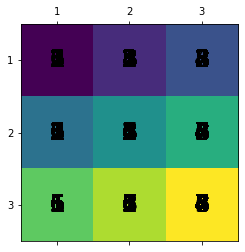

In [15]:
def sliding_blocks_animation(solution):
    image = np.zeros((K, K))
    labels = range(1, K + 1)

    fig, ax = plt.subplots()
    plt.xticks(range(K), labels)
    plt.yticks(range(K), labels)

    grid = ax.matshow(image, cmap="viridis")

    def animate(i=0):
        image = np.array(solution.states[i]).reshape((K, K))
        ax.texts = []
        for (i, j), z in np.ndenumerate(image):
            if z != 0:
                ax.text(j, i, z, ha="center", va="center", fontsize=24)
        return [ax.matshow(image, cmap="viridis")]

    anim = animation.FuncAnimation(
        fig, animate, init_func=animate, 
        frames=len(solution.states), interval=7,
        blit=True, repeat=False
    )
    return anim


anim = sliding_blocks_animation(solution)
HTML(anim.to_html5_video())

In [16]:
# saving to m4 using ffmpeg writer
writervideo = animation.FFMpegWriter(fps=15)
anim.save('./assets/N_Puzzle.mp4', writer=writervideo)
plt.close()

In [19]:
# Test
len(solution.states)

175